In [1]:
library(Seurat)
library(ComplexHeatmap)
library(dplyr)


inputdir <- "./load_files/"
outputdir <- "./report/"

pat <- readRDS(file = paste0(inputdir, "PAT_inte.organizer.inte.rds"))
sel_cls <- c("PC FGF17", "PC NKX2-1 NKX6-2", "PC NKX2-1 LMO1", 
             "GE_RG_NKX2-1_DLK1", "GE_RG_NKX2-1_OLIG1", 
             "PC RSPO3", "PC TTR", "PC SFRP2", "PC TCF7L2")
pat@meta.data$cluster <- factor(as.character(pat@meta.data$subtype), levels = sel_cls)

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Loading required package: grid

ComplexHeatmap version 2.2.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
source("./pat.fun.R")

In [3]:
## Do the marker calculation
marFile <- paste0(inputdir, "PAT_markers.Rdata")
if (!file.exists(marFile)){
    ## downsample each organizer subtype to have the balanced number of cells
    set.seed(42)
    sel_cls <- c("PC FGF17", "PC NKX2-1 LMO1", "PC NKX2-1 NKX6-2", 
                 "GE_RG_NKX2-1_DLK1", "GE_RG_NKX2-1_OLIG1", 
                 "PC RSPO3", "PC TTR", "PC SFRP2", "PC TCF7L2")
    slim_cells <- lapply(sel_cls, function(x) {
                    cells <- colnames(seu)[seu@meta.data$subtype == x]
                    if (length(cells) > 1000){
                        cells <- sample(cells, 1000)
                    }
                    cells
                    }) %>% 	
                            unlist()
    slim_pat <- seu[, slim_cells]

    
    ## Find markers
    Idents(slim_pat) <- "subtype"
    mar_res <- lapply(sel_cls, function(x) {
        mm <- FindMarkers(slim_pat, ident.1 = x, 
                          logfc.threshold = 0.1, min.pct = 0.05, 
                          only.pos = TRUE, max.cells.per.ident = 1000) %>%
                rownames_to_column("gene") %>%
                mutate(ratio_fc = (pct.1 + 0.01)/(pct.2 + 0.01))
        mm
        }) %>% 
                setNames(., sel_cls)
    save(mar_res, file = paste0(inputdir, "PAT_markers.Rdata"))
}


In [4]:
## Extract the organizer markers
load(file = paste0(inputdir, "PAT_markers.Rdata"))
new.list <- readRDS(file = "./load_files/Pathway_updated_20221219.rds") ## signaling pathway annotations


## Get cell cycle genes, and remove them in the marker output (avoid confounding by cell cycles)
cc_genes <- get_genes(input_genes = rownames(pat), gene_type = "cc", revised = TRUE)


slim_res <- lapply(sel_cls, function(cls) {
    ## update cluster names to avoid inconsistency
    ncls <- gsub("PC NKX2-1", "AV NKX2-1", cls) %>%
                    gsub("GE_RG_NKX2-1_DLK1", "GE RG NKX2-1 DLK1", .) %>%
                    gsub("GE_RG_NKX2-1_OLIG1", "GE RG NKX2-1 OLIG1", .)

    yy <- mar_res[[cls]] %>%
            subset(ratio_fc >= 1.1) %>%
            subset(pct.1 >= 0.1) %>%
            subset(!gene %in% cc_genes) %>%
            mutate(p_val_adj = p.adjust(p_val, method = "fdr")) %>%
            subset(p_val_adj <= 0.01) %>%
            arrange(desc(ratio_fc)) %>%
            ungroup() %>%
            mutate(cluster = ncls)
    ## Add pathway annotation
    for (pa in names(new.list)){
        yy[, paste0("Pathway_", pa)] <- ifelse(yy$gene %in% new.list[[pa]], 1, 0)
    }

    return(yy)
    }) %>%
        do.call(rbind, .)
slim_res
write.table(slim_res, file = "./report/PAT_markers_table.txt", 
            row.names = FALSE, col.names = TRUE, sep = "\t", quote = FALSE)

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,ratio_fc,cluster,Pathway_BMP,Pathway_EPH,Pathway_FGF,Pathway_NOTCH,Pathway_WNT,Pathway_RA,Pathway_SHH
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FGF17,5.250664e-256,3.0843909,0.791,0.018,2.210530e-253,28.607143,PC FGF17,0,0,1,0,0,0,0
FGF18,2.290939e-58,0.8820602,0.258,0.011,1.071650e-56,12.761905,PC FGF17,0,0,1,0,0,0,0
FGF3,1.284948e-27,0.6075258,0.115,0.003,1.690509e-26,9.615385,PC FGF17,0,0,1,0,0,0,0
SP8,1.294735e-83,0.9034394,0.373,0.033,1.090167e-81,8.906977,PC FGF17,0,0,0,0,0,0,0
LYN,3.139621e-23,0.2759942,0.105,0.004,3.004046e-22,8.214286,PC FGF17,0,1,0,0,0,1,0
FGF8,5.335056e-33,0.9133850,0.181,0.014,8.318735e-32,7.958333,PC FGF17,0,0,1,0,0,0,0
AGR3,3.739002e-21,0.3729995,0.108,0.008,3.086510e-20,6.555556,PC FGF17,0,0,0,0,0,0,0
SMOC1,2.580706e-36,0.5294617,0.198,0.022,4.526989e-35,6.500000,PC FGF17,0,0,0,0,0,0,0
ETV4,2.454617e-29,0.3785356,0.151,0.015,3.444646e-28,6.440000,PC FGF17,0,0,0,0,0,0,0


In [5]:
## Also save in rds format & modify the cluster names
slim_res_save <- slim_res %>%
            mutate(cluster = gsub("^AV NKX2-1", "AntVen NKX2-1", cluster))
saveRDS(slim_res_save, file = paste0(inputdir, "PAT_markers_withincompare.rds"))

In [6]:
## Extract the top 100 markers for heatmap visualization
sel_cls <- c("PC FGF17", "PC NKX2-1 LMO1", "PC NKX2-1 NKX6-2", 
                 "GE_RG_NKX2-1_DLK1", "GE_RG_NKX2-1_OLIG1", 
                 "PC RSPO3", "PC TTR", "PC SFRP2", "PC TCF7L2")
mars <- lapply(sel_cls, function(cls) {
    yy <- mar_res[[cls]] %>%
            subset(ratio_fc >= 1.1) %>%
            subset(pct.1 >= 0.1) %>%
            subset(!gene %in% cc_genes) %>%
            mutate(p_val_adj = p.adjust(p_val, method = "fdr")) %>%
            subset(p_val_adj <= 0.01) %>%
            arrange(desc(ratio_fc)) %>%
            ungroup() %>%
            top_n(., 100, wt = ratio_fc) %>%
            .$gene
    yy
    }) %>%
        setNames(., sel_cls)
lapply(mars, head, 20)

$`PC FGF17`
 [1] "FGF17"        "FGF18"        "FGF3"         "SP8"          "LYN"         
 [6] "FGF8"         "AGR3"         "SMOC1"        "ETV4"         "GALP"        
[11] "DUSP6"        "LOX"          "ETV5"         "LOC715487"    "LOC114677713"
[16] "TMEM132D"     "SPRY1"        "PCDH11X"      "IL17RD"       "ISLR2"       

$`PC NKX2-1 LMO1`
 [1] "FRZB"    "SPARCL1" "SLC10A4" "DLX2"    "POMC"    "DLX1"    "OLIG1"  
 [8] "NKX2-1"  "EDNRB"   "COL9A3"  "LMO1"    "OLIG2"   "DLK1"    "MBIP"   
[15] "FZD5"    "EPHB3"   "HEY1"    "LOX"     "PDSS1"   "SLC9A6" 

$`PC NKX2-1 NKX6-2`
 [1] "NKX6-2"    "TMEM132B"  "SPON1"     "DIO3"      "SHH"       "MCTP1"    
 [7] "VAX1"      "LOC711450" "LMO2"      "CRYGD"     "FZD5"      "SLC35D2"  
[13] "FOXO1"     "VGF"       "SPARCL1"   "GRIK3"     "SOX3"      "MAGEL2"   
[19] "EFNA5"     "SCRG1"    

$`GE_RG_NKX2-1_DLK1`
 [1] "HOPX"         "MEIS2"        "ESRRG"        "TRIM9"        "FSTL5"       
 [6] "THSD4"        "SEMA5A"       "SFRP1"        "SALL1"        "MCC"         
[11] "POU3F3"       "PSD3"         "GAP43"        "LOC106993104" "TSPAN7"      
[16] "STMN2"        "HS6ST2"       "FZD8"         "DDAH1"        "PDLIM3"      

$`GE_RG_NKX2-1_OLIG1`
 [1] "DLX2"         "OLIG2"        "DLX1"         "LMO1"         "GSX2"        
 [6] "SOX8"         "PCDH10"       "NKX2-1"       "SFRP1"        "ASCL1"       
[11] "CORO1C"       "OLIG1"        "POU3F3"       "GNG4"         "STMN2"       
[16] "LOC106993104" "NKAIN3"       "MN1"          "MEIS2"        "THSD4"       

$`PC RSPO3`
 [1] "RSPO2"        "WNT2B"        "LOC716075"    "SULT1E1"      "HEY2"        
 [6] "WNT8B"        "LOC106998157" "LOC106998526" "SULF2"        "B3GAT2"      
[11] "CALB1"        "EFHD1"        "MASP1"        "CADPS"        "DMRT3"       
[16] "RSPO3"        "LHX9"         "SP5"          "EMX1"         "RORA"        

$`PC TTR`
 [1] "CLIC6"    "QRICH2"   "IGFBP7"   "CA2"      "SNTG1"    "RBM47"   
 [7] "COLEC12"  "SOSTDC1"  "HTR2C"    "SLC17A8"  "SLC38A11" "DKK2"    
[13] "CFAP126"  "PCP4"     "CAPSL"    "CLDN19"   "MSX1"     "SLC16A10"
[19] "PIFO"     "TMEM88"  

$`PC SFRP2`
 [1] "SFRP2"        "SNCA"         "WNT7B"        "C5H4orf45"    "VCAM1"       
 [6] "PENK"         "NTRK2"        "PAX6"         "HTRA1"        "LOC114679021"
[11] "NCALD"        "DCUN1D4"      "PTX3"         "NR2F2"        "COL11A1"     
[16] "TMEM132D"     "FAM181A"      "FEZF1"        "SIPA1L2"      "ARX"         

$`PC TCF7L2`
 [1] "NTS"          "WNT4"         "BARHL2"       "IRX3"         "SHOX2"       
 [6] "FZD10"        "LOC106994320" "TAL2"         "LOC106999599" "WNT3"        
[11] "PDZRN4"       "APCDD1"       "IRX5"         "IRX2"         "PDIA5"       
[16] "NTNG1"        "LOC114678382" "GRID2"        "TPD52"        "CRNDE"

In [7]:
## Prepare data for Heatmap visualization

## Seurat object
## 200 cells per subtype
set.seed(42)
pat_plot <- lapply(sel_cls, function(x) {
    cells <- colnames(pat)[pat@meta.data$subtype == x]
    if (length(cells) > 200){
        cells <- sample(cells, 200)
    }
    cells
    }) %>% 	
            unlist() %>%
            pat[, .]

## scaled data for visualization
mat <- lapply(c("PC FGF17", "PC NKX2-1", "GE RG NKX2-1", 
                "PC RSPO3", "PC TTR", "PC SFRP2", "PC TCF7L2"), function(cls) {
    ncls <- cls
    if (cls == "PC NKX2-1"){
        ncls <- c("PC NKX2-1 NKX6-2", "PC NKX2-1 LMO1")
    } else if (cls == "GE RG NKX2-1"){
        ncls <- c("GE_RG_NKX2-1_DLK1", "GE_RG_NKX2-1_OLIG1")
    }

    genes <- mars[ncls] %>% unlist() %>% unique()
    submat <- pat_plot[["RNA"]]@data[genes, ] %>% 
                as.matrix() %>%
                t() %>% scale() %>% t() %>%
                MinMax(., min = -1.5, max = 2)
    rownames(submat) <- paste0(cls, "|", rownames(submat))
    submat
    }) %>%
        do.call(rbind, .)

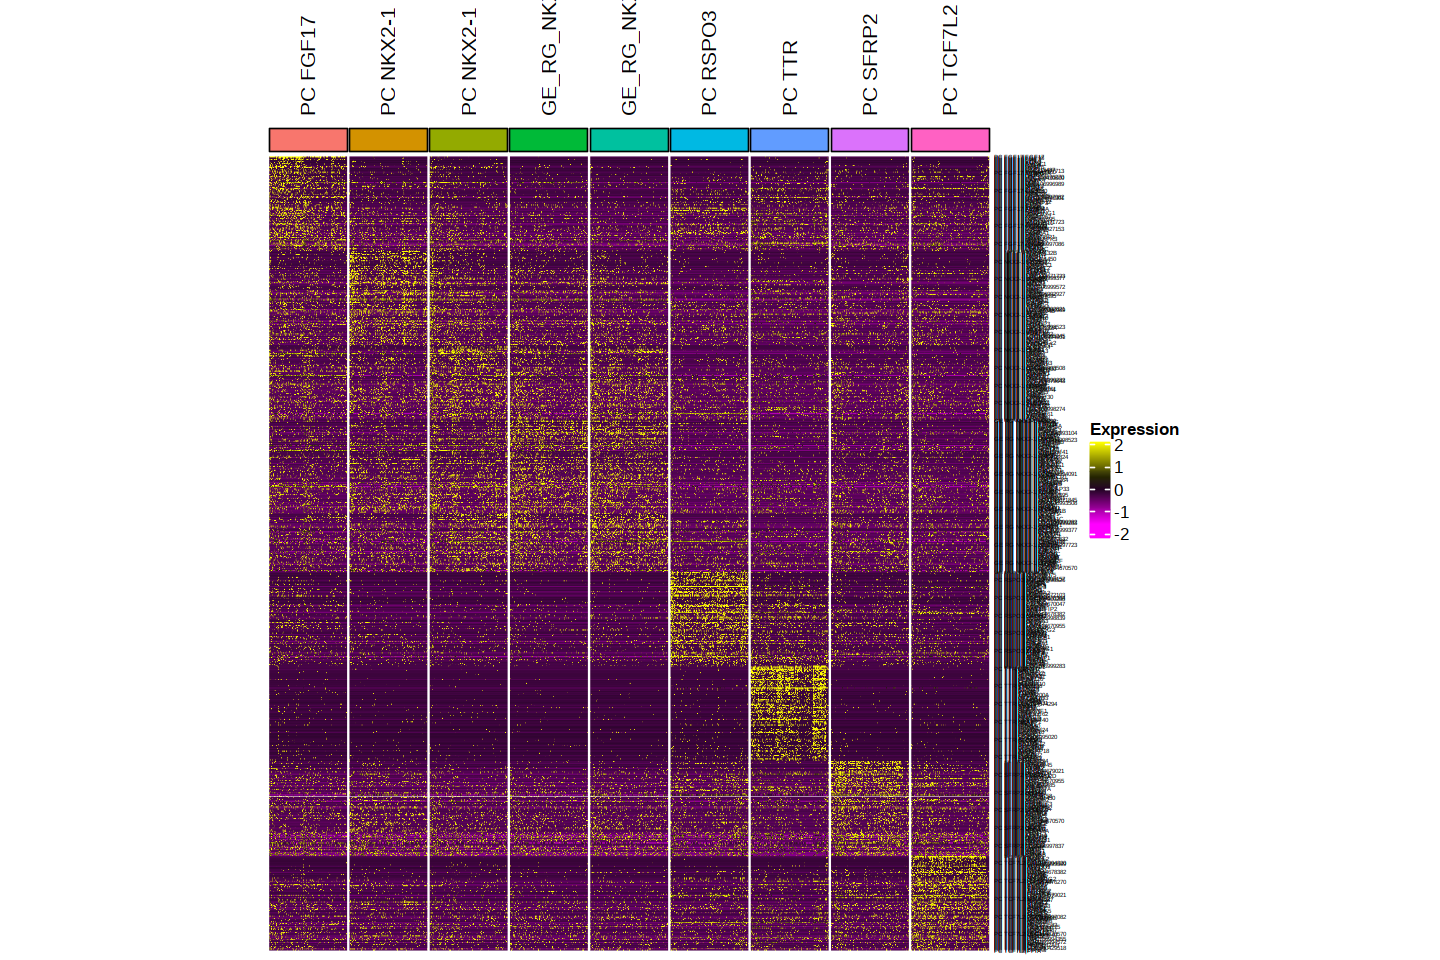

In [8]:
## genes to highlight/label
path_gset <- list(`PC FGF17` = c("DLK1", "FGF17", "ZIC1", "FGF18", "FGF8", "FGF3", "SP8", 
                                 "ZIC4", "ZIC3", "SPRY2", "ETV1", "OTX2"),
                `PC NKX2-1` = c("DLK1", "SHH", "NKX6-2", "SOX3", "DLX2", "OLIG1", "OLIG2", 
                                "ASCL1", "NKX2-1", "SOX6", "FOXG1", "DKLK1"),
                `GE RG NKX2-1` = c("LAMP3", "POU3F3", "POU3F2", "NES", "FOXG1", "MAP2", 
                                   "ZEB1", "ZEB2", "HMGB2", "HMGA2", "OLIG2", "MEIS2", "PBX3", "GSX2", "FGFR2"),
                `PC RSPO3` = c("WNT2B", "TCF4", "LHX9", "FGF13", "RSPO2", "RSPO3", "DMRTA2", 
                               "EMX2", "SP5", "WNT8B", "CALB1", "BAMBI", "FGFR3", "ARX", "LMX1A"),
                `PC TTR` = c("BMP4", "NPY1R", "CA2", "TTR", "FOXJ1", "PKNOX2", "FGFR2"),
                `PC SFRP2` = c("PAX6", "SFRP2", "NR2F2", "NR2F1"),
                `PC TCF7L2` = c("IRX3", "TCF7L2", "WNT4", "WNT3", "OTX1", "GLI2"))


fun1 <- colorRampPalette(c("#FF00FF", "black", "#FFFF00"))
col_fun = circlize::colorRamp2(c(-1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2), fun1(8))
htlist <- Heatmap(mat, name = "Expression",  
        column_split = pat_plot@meta.data$cluster,
        cluster_columns = TRUE,
        show_column_dend = FALSE,
        cluster_column_slices = FALSE,
        cluster_row_slices = FALSE,
        column_title_gp = gpar(fontsize = 12),
        row_title_gp = gpar(fontsize = 0),
        column_gap = unit(0.5, "mm"),
        cluster_rows = FALSE,
        show_row_dend = FALSE,
        col = col_fun,
        row_names_gp = gpar(fontsize = 3),
        column_title_rot = 90,
        top_annotation = HeatmapAnnotation(foo = anno_block(gp = gpar(fill = scales::hue_pal()(9)))),
        show_column_names = FALSE,
        show_row_names = TRUE,
        use_raster = TRUE,
        raster_quality = 4, 
        width = unit(6, "in"))
options(repr.plot.width=12, repr.plot.height=8)
draw(htlist)

[1] "PC FGF17"
[1] "PC NKX2-1"
[1] "GE RG NKX2-1"
[1] "PC RSPO3"
[1] "PC TTR"
[1] "PC SFRP2"
[1] "PC TCF7L2"


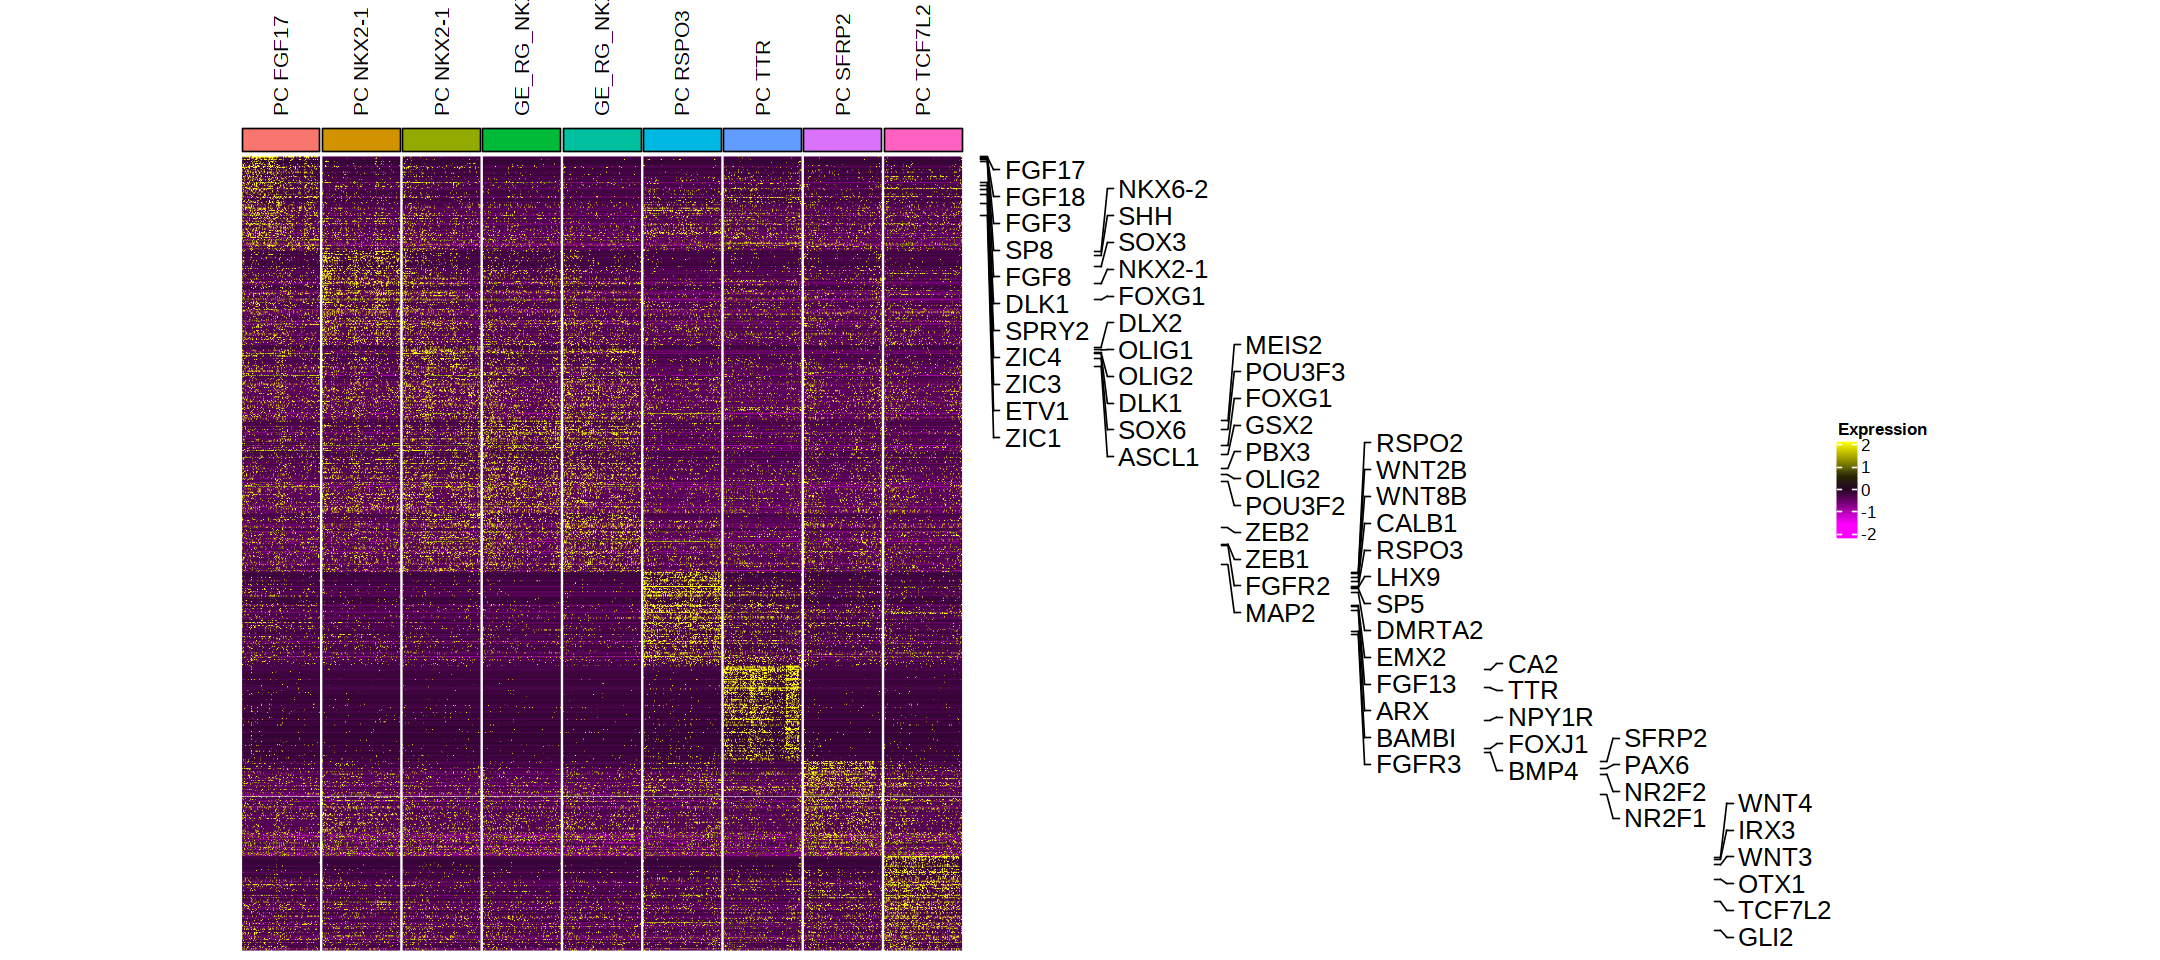

In [9]:
## Match gene orders
match_order <- function(all_genes, selected_genes) {
            selected_genes[match(all_genes[all_genes %in% names(selected_genes)], names(selected_genes))]
        }
for (ii in names(path_gset)){
    print(ii)
    genes <- path_gset[[ii]]
    mat_genes0 <- sapply(genes, function(x) {
                xx <- grep(paste0("\\|", x, "$"), rownames(mat), value = TRUE)
                if (length(xx)>= 1){
                    return(xx)
                } else {
                    return("")
                }
                }) %>% unlist()
    mat_genes <- mat_genes0[sapply(mat_genes0, function(x) x != "")]
    mat_genes <- grep(paste(ii, collapse = "|"), mat_genes, value = TRUE)
    label_genes <- setNames(extract_field(mat_genes, 2, "|"), setNames(mat_genes, NULL))
    if (sum(names(label_genes) %in% rownames(mat)) > 0){
        htlist <- htlist + 
                HeatmapAnnotation(link = anno_mark(at = which(rownames(mat) %in% names(label_genes)), 
                                    labels = setNames(match_order(rownames(mat), label_genes), NULL), 
                                    side = "right",
                                    labels_gp = gpar(fontsize = 15), padding = unit(1, "mm")),
                                which = "row",
                                name = ii)
    }
}
options(repr.plot.width=18, repr.plot.height=8)
draw(htlist)

In [10]:
pdf(paste0(outputdir, "PAT_markers_heatmap_combine_selected.pdf"), width = 16, height = 10)
draw(htlist)
dev.off() 

png 
  2

In [11]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRblas.so
LAPACK: /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
[1] dplyr_1.0.7          ComplexHeatmap_2.2.0 Seurat_3.1.5        

loaded via a namespace (and not attached):
 [1] nlme_3.1-147        tsne_0.1-3          RcppAnnoy_0